In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
pop_size = 100
features = 50
selection = 0.2
mutation = 1. / pop_size
generations = 200
num_parents = int(pop_size * selection)
num_children = pop_size - num_parents

In [3]:
with tf.Session() as sess:
    truth = np.sin(2 * np.pi * (np.arange(features, dtype=np.float32)) / features)
    
    population = tf.Variable(np.random.randn(pop_size, features), dtype=tf.float32)
    truth_ph = tf.placeholder(tf.float32, [1, features])
    crossover_mat_ph = tf.placeholder(tf.float32, [num_children, features])
    mutation_val_ph = tf.placeholder(tf.float32, [num_children, features])
    fitness = -tf.reduce_mean(tf.square(tf.subtract(population, truth_ph)), 1)
    
    top_vals, top_ind = tf.nn.top_k(fitness, k=pop_size)
    best_val = tf.reduce_min(top_vals)
    best_ind = tf.arg_min(top_vals, 0)
    best_individual = tf.gather(population, best_ind)
    
    population_sorted = tf.gather(population, top_ind)
    parents = tf.slice(population_sorted, [0, 0], [num_parents, features])
    
    rand_parent1_ix = np.random.choice(num_parents, num_children)
    rand_parent2_ix = np.random.choice(num_parents, num_children)
    rand_parent1 = tf.gather(parents, rand_parent1_ix)
    rand_parent2 = tf.gather(parents, rand_parent2_ix)
    rand_parent1_sel = tf.multiply(rand_parent1, crossover_mat_ph)
    rand_parent2_sel = tf.multiply(rand_parent2, tf.subtract(1., crossover_mat_ph))
    children_after_sel = tf.add(rand_parent1_sel, rand_parent2_sel)
    
    mutated_children = tf.add(children_after_sel, mutation_val_ph)
    new_population = tf.concat(axis=0, values=[parents, mutated_children])
    
    step = tf.group(population.assign(new_population))
    
    init = tf.global_variables_initializer()
    sess.run(init)
    
    for i in range(generations):
        crossover_mat = np.ones(shape=[num_children, features])
        crossover_point = np.random.choice(np.arange(1, features - 1, step=1), num_children)
        
        for pop_ix in range(num_children):
            crossover_mat[pop_ix, 0:crossover_point[pop_ix]] = 0
        
        mutation_prob_mat = np.random.uniform(size=[num_children, features])
        mutation_values = np.random.normal(size=[num_children, features])
        mutation_values[mutation_prob_mat >= mutation] = 0
        
        feed_dict = {
            truth_ph: truth.reshape([1, features]),
            crossover_mat_ph: crossover_mat,
            mutation_val_ph: mutation_values,
        }
        step.run(feed_dict, session=sess)
        best_individual_val = sess.run(best_individual, feed_dict=feed_dict)
        
        if i % 5 == 0:
            best_fit = sess.run(best_val, feed_dict=feed_dict)
            print('Generation: {}, Best Fitness (lowest MSE): {:.2}'.format(
                i, -best_fit))

Instructions for updating:
Use `argmin` instead
Generation: 0, Best Fitness (lowest MSE): 1.6
Generation: 5, Best Fitness (lowest MSE): 0.6
Generation: 10, Best Fitness (lowest MSE): 0.43
Generation: 15, Best Fitness (lowest MSE): 0.35
Generation: 20, Best Fitness (lowest MSE): 0.34
Generation: 25, Best Fitness (lowest MSE): 0.32
Generation: 30, Best Fitness (lowest MSE): 0.2
Generation: 35, Best Fitness (lowest MSE): 0.14
Generation: 40, Best Fitness (lowest MSE): 0.18
Generation: 45, Best Fitness (lowest MSE): 0.16
Generation: 50, Best Fitness (lowest MSE): 0.21
Generation: 55, Best Fitness (lowest MSE): 0.14
Generation: 60, Best Fitness (lowest MSE): 0.2
Generation: 65, Best Fitness (lowest MSE): 0.095
Generation: 70, Best Fitness (lowest MSE): 0.16
Generation: 75, Best Fitness (lowest MSE): 0.12
Generation: 80, Best Fitness (lowest MSE): 0.15
Generation: 85, Best Fitness (lowest MSE): 0.06
Generation: 90, Best Fitness (lowest MSE): 0.17
Generation: 95, Best Fitness (lowest MSE): 0.

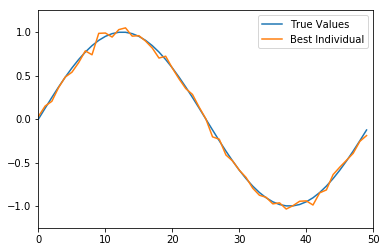

In [4]:
plt.plot(truth, label="True Values")
plt.plot(np.squeeze(best_individual_val), label="Best Individual")
plt.axis((0, features, -1.25, 1.25))
plt.legend(loc='upper right')
plt.show()